**Convolutional Neural Network**
---



In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import kagglehub
from matplotlib import pyplot as plt

In [3]:
# Definición de capas de red neuronal

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass


class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (
            depth,
            input_height - kernel_size + 1,
            input_width - kernel_size + 1,
        )
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(
                    self.input[j], output_gradient[i], "valid"
                )
                input_gradient[j] += signal.convolve2d(
                    output_gradient[i], self.kernels[i, j], "full"
                )

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient


class MaxPooling(Layer):
    def __init__(self, input_shape, size):
        depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.depth = depth
        self.size = size
        self.output_shape = (
            depth,
            int(np.ceil(input_height / size)),
            int(np.ceil(input_width / size)),
        )

    def forward(self, input):
        self.input = input
        self.output = np.zeros(self.output_shape)
        for d in range(self.depth):
            for i in range(self.output_shape[1]):
                for j in range(self.output_shape[2]):
                    i_input = i * self.size
                    j_input = j * self.size
                    self.output[d, i, j] = np.max(
                        self.input[
                            d,
                            i_input : i_input + self.size,
                            j_input : j_input + self.size
                        ]
                    )
        return self.output

    def backward(self, output_gradient, learning_rate=0):
        input_gradient = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.output_shape[1]):
                for j in range(self.output_shape[2]):
                    i_input = i * self.size
                    j_input = j * self.size
                    subarea = self.input[
                        d,
                        i_input : i_input + self.size,
                        j_input : j_input + self.size
                    ]
                    idx = np.nanargmax(subarea)
                    y_offset, x_offset = np.unravel_index(idx, subarea.shape)
                    input_gradient[
                        d,
                        i_input + y_offset,
                        j_input + x_offset
                    ] = output_gradient[d, i, j]
        return input_gradient


class Dropout(Layer):
    def __init__(self, probability):
        self.probability = probability

    def forward(self, input):
        self.input = input
        self.mask = np.random.choice(
            [0, 1], self.input.shape, [self.probability, 1 - self.probability]
        )
        return self.input * self.mask

    def backward(self, output_gradient, learning_rate):
        return output_gradient * self.mask

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient


class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)


In [4]:
# Definición de capas de activación

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))


class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)


class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)


class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot(
            (np.identity(n) - self.output.T) * self.output, output_gradient
        )


In [5]:
# Funciones de entrenar y predecir entradas

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output


def train(
    network,
    loss,
    loss_prime,
    x_train,
    y_train,
    epochs=1000,
    learning_rate=0.01,
    verbose=True,
):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")


In [6]:
# Funciones para calcular error y pérdida

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))


def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)


def binary_cross_entropy(y_true, y_pre):
    return np.mean(-y_true * np.log(y_pre) - (1 - y_true) * np.log(1 - y_pre))


def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [7]:
# Función de preprocesado para dataset MNIST

def preprocess(x: np.ndarray, y: np.ndarray, nclasses: int, limit: int):
    indexes = np.where(y == 0)[0][:limit]
    for c in range(1, nclasses):
        index = np.where(y == c)[0][:limit]
        indexes = np.hstack((indexes, index))
    rng = np.random.default_rng()
    indexes = rng.permutation(indexes)
    x, y = x[indexes], y[indexes]

    x = x.reshape((-1, 1, 28, 28))
    x = x.astype(np.float32) / 255

    y = np.identity(nclasses)[y]
    y = np.expand_dims(y, -1)

    return x, y

In [8]:
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sign-language-mnist' dataset.
Path to dataset files: /kaggle/input/sign-language-mnist


In [9]:
nclasses = 26
limit = 1000

In [10]:
# Test network
network = [
    Convolutional((1, 28, 28), 3, 5),
    MaxPooling((5, 26, 26), 2),
    Sigmoid(),
    Reshape((5, 13, 13), (5 * 13 * 13, 1)),
    Dense(5 * 13 * 13, nclasses),
    Softmax(),
]

In [11]:
train_file = path + "/sign_mnist_train/sign_mnist_train.csv"
test_file = path + "/sign_mnist_test/sign_mnist_test.csv"
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']
x_train = train_df.values
x_test = test_df.values
x_train, y_train = preprocess(x_train, y_train, nclasses, limit)
x_test, y_test = preprocess(x_test, y_test, nclasses, limit)

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


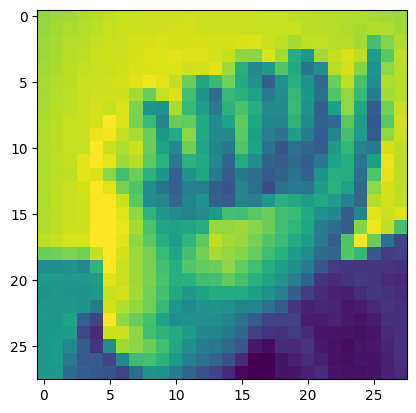

In [12]:
plt.imshow(x_train[0, 0])
plt.show()

In [13]:
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    1,
)

1/1, error=0.23395255353663041


3


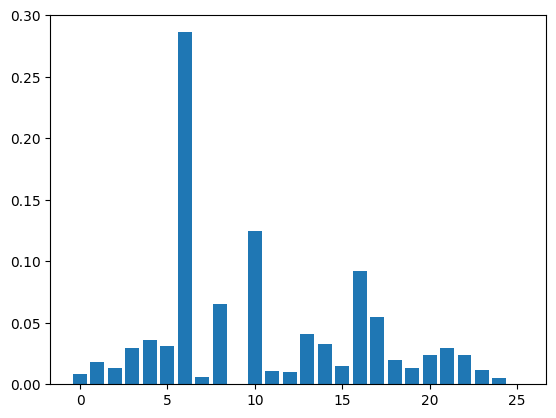

In [14]:
i = 200

probs = predict(network, x_test[i])
print(np.argmax(y_test[i]))

plt.bar(np.arange(nclasses), probs[:,0])
plt.show()

In [102]:
probst = []
indexes = np.random.choice(len(x_test), (50, ))
for i in indexes:
    res = predict(network, x_test[i])
    probst.append(res.T[0])

probst = np.array(probst)
labels = np.argmax(y_test[indexes], axis=1)

In [103]:
import networkx as nx
import numpy as np

#values = np.random.rand(100,10)
resultados = probst

def sim(s1, s2):
    s1_arr = np.asarray(s1)
    s2_arr = np.asarray(s2)

    sum_sq_diff = np.sum(np.square(s1_arr - s2_arr))

    return np.sqrt(sum_sq_diff) / np.sqrt(len(s1))

def dist(s1, s2):
    s1_arr = np.asarray(s1)
    s2_arr = np.asarray(s2)

    sum_sq_diff = np.sum(np.square(s1_arr - s2_arr))

    return np.sqrt(sum_sq_diff)

distancias = []
for i in range(len(resultados)-1):
  for j in range(i+1,len(resultados)):
    distancias.append((i, j,dist(resultados[i], resultados[j])))

aristas = []
for i in range(len(resultados)-1):
  for j in range(i+1,len(resultados)):
    x = sim(resultados[i], resultados[j])
    #if x > 0.5:
    aristas.append((i, j, x))

def find(raiz, i):
    if raiz[i] == i:
        return i
    return find(raiz, raiz[i])

def union(padre, rank, x, y):
    raizx = find(padre, x)
    raizy = find(padre, y)
    if raizx != raizy:
        if rank[raizx] < rank[raizy]:
            padre[raizx] = raizy
        elif rank[raizx] > rank[raizy]:
            padre[raizy] = raizx
        else:
            padre[raizy] = raizx
            rank[raizx] += 1

def kruskal(nodos, num_nodos):
    MSTk = []
    i = 0
    aristas = sorted(nodos, key=lambda item: item[2])

    padre = list(range(num_nodos))
    rank  = [0] * num_nodos

    while i < len(aristas):
        nog, nod, peso = aristas[i]
        i+=1

        x = find(padre, nog)
        y = find(padre, nod)
        if x != y:
            MSTk.append((nog, nod, peso))
            union(padre, rank, x, y)

    return MSTk

MST_Kruskal = kruskal(aristas, len(resultados))

print("MST de Kruskal")

Peso_total = 0
for arista in MST_Kruskal:
    Peso_total += arista[2]
    # print(f'{arista[0]} -> {arista[1]}: {arista[2]}')

print("Peso total(K): ", Peso_total)

MST de Kruskal
Peso total(K):  1.561019093848095


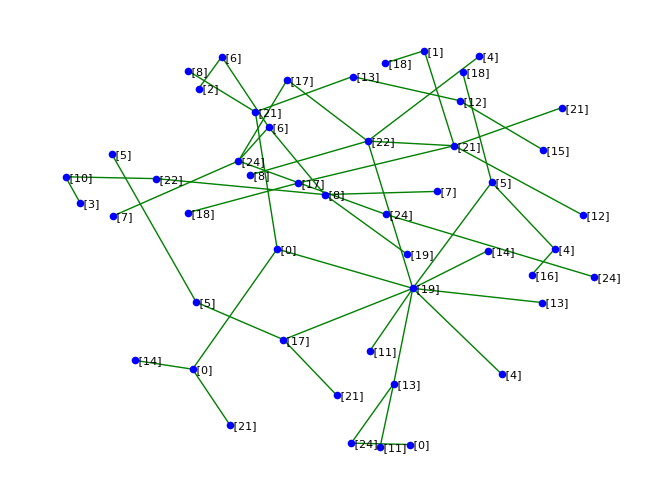

In [105]:
# Dibujar grafo
G = nx.Graph()
for i, name in enumerate(labels):
    G.add_node(i, label=" " + str(name))

G.add_weighted_edges_from(MST_Kruskal)

pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='b', edge_color='g', node_size=20)

labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=8, horizontalalignment="left")

plt.show()